# Tequila Tutorial: 
## Handling Optimizers, Initializing parametrized circuits

In [1]:
# Import everything we need here
import tequila as tq
import numpy

In the following example we will optimize a simple two qubit VQE with an Ansatz that is parametrized by two parameters.
The Hamiltonian is also very simple and defined in the box below.
$$ H = \sigma_x(1) + c \sigma_z(1) - \sigma_z(0)$$

<br>
The tutorial is \textbf{not} a guideline to optimization strategies but only intends to show tequilas functionality

In [2]:
c = 0.001
H = tq.paulis.X(1) + 0.0*c*tq.paulis.Z(1)

Lets take a look at the spectrum of this very simple Hamiltonian  
Keep in mind: Tequila is not a numerical linear algebra package, so better not try to diagonalize Hamiltonians  
we however added this feature for user convenience in examples  
In the future we might have interfaces to more powerfull numerical packages ... feel free to contribute :-) 

In [3]:
matrix = H.to_matrix()
e, v = numpy.linalg.eigh(matrix)
e

array([-1., -1.,  1.,  1.])

And here we initialize our Ansatz circuit which is parametrized by a and b.<br>

We show to ways to initialize Variables:
Variable a is initialized with a convenience string based initialization <br>
Variable b is initialized as Variable which allows you to conveniently transforming it when initializing gates. Here we do a simple rescaling as an example <br>
Note that you don't need strings to name variables but can use any hashable non-numeric type (meaning anything that is not interpreted as number). 

For example: tq.Variable(name=(0,1,2,3)) will also work


The Ansatz has no specific meaning and it is more to show different ways how to deal with variables.
See for instance that you can scale them and use the same variable in multiple gates. (See the other tutorials for more examples)  

What essentially happens in this example is, that the variable $a$ needs to switch on the control qubit
and variable $b$ finds the effective one qubit minimum. So it is a quite useless artificial system

In [4]:
b = tq.Variable(name="b")

U = tq.gates.Ry(target=0, angle='a')
U += tq.gates.Ry(target=1, control=0, angle=b/2)
U += tq.gates.X(target=1)
U += tq.gates.Ry(target=1, control=0, angle=-b/2)
U += tq.gates.Rx(target=0,angle=1.234)


In [5]:
print(U)

circuit: 
Ry(target=(0,), parameter=a)
Ry(target=(1,), control=(0,), parameter=Objective with 0 expectation values
Objective = f(b)
variables = [b])
X(target=(1,))
Ry(target=(1,), control=(0,), parameter=Objective with 0 expectation values
Objective = f(b)
variables = [b])
Rx(target=(0,), parameter=1.234)



In [6]:
# nice output (depends on which backends you have)
tq.draw(U)

0: ───Ry(0.0π)───@────────────────@─────────────Rx(0.393π)───
                 │                │
1: ──────────────Ry(0.159π)───X───Ry(-0.159π)────────────────


/home/jsk/anaconda3/envs/tequila-3.6/lib/python3.6/site-packages/jax/lib/xla_bridge.py:118: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In the next box we form an objective out of our Hamiltonian and our Ansatz and pass it down to the optimizer.
In the following boxes we show how the results of the optimizer can be plotted

See farther below for some small exercises and additional information  

We will also set the initial values of the variables that can be passed to the optimizer.  
Values of variables are passed as dictionaries where the keys are tequila variables and the values are floats.  

In [7]:
initial_values = {'a':0.1, 'b':0.1}
O = tq.Objective.ExpectationValue(U=U, H=H)
result = tq.optimizer_scipy.minimize(objective=O, initial_values=initial_values)

ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting BFGS optimization
Objective: 1 expectationvalues
Gradients: 10 expectationvalues (min=2, max=8)

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
E= 0.0002493756473995745  angles= {a: 0.1, b: 0.1}  samples= None
E= 0.0002195803972426802  angles= {a: 0.09501664191484452, b: 0.09751456081867219}  samples= None
E= 0.00012320707901380956  angles= {a: 0.07508320957422257, b: 0.0875728040933609}  samples= None
E= 1.5390127373393625e-05  angles= {a: 0.030551060312040093, b: 0.06600833950542084}  samples= None
E= 2.388447683188133e-06  angles= {a: 0.012868225367150547, b: 0.057727881592791484}  samples= None
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5


In [8]:
# final energy
result.energy

2.388447683188133e-06

Lets simulate the objective directly with different values for the variables

In [27]:
energy = tq.simulate(O, variables={"a": 0.1, "b":0.1})
print(energy)

0.0002493756473995745


And for the case that you want to simulate the wavefunction

In [28]:
wfn = tq.simulate(U,variables={"a": 0.1, "b":0.1})
print(wfn)

-0.0014i|00> +0.0020|10> +0.8151e^(0.5113πi)|01> +0.5793e^(0.9776πi)|11> 


In [9]:
# final angles
result.angles

{a: 0.012868225367150547, b: 0.057727881592791484}

Plot out the History:
Note, that we choose bad initial points since they are close to the maximum

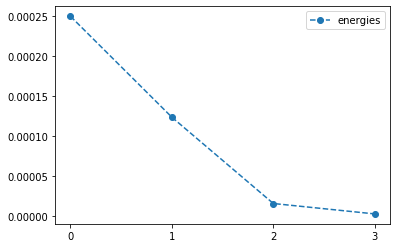

In [10]:
result.history.plot('energies')

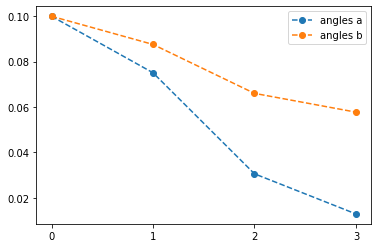

In [11]:
result.history.plot(property='angles', key=[tq.Variable("a"), tq.Variable("b")])

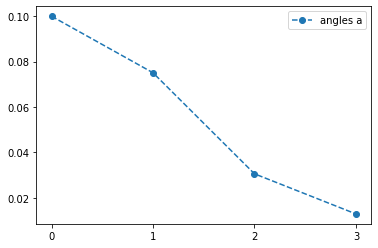

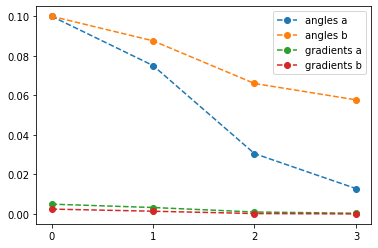

In [12]:
# Convenience in the history plot
result.history.plot(property='angles', key="a")
result.history.plot(property=['angles', 'gradients'], key=["a", "b"])

# FAQ

## 1: How can I extract the parameters from a given circuit?

Call the 'extract_parameters' attribute and get back a list of all Variables in the circuit

In [13]:
angles = U.extract_variables()
angles

[a, b]

## 2: How can I do measurement based simulation?
Pass down the 'samples' keyword to simulate finite samples
See the later exercises to play around with sample number and optimization methods.

Feel free to play around with the number of samples 
Don't excpect miracles from the optimizer, you might need to hit return a few times or increase the number of samples.<br>Note that stochastic gradients are not yet supported
<br>Note also that we did not set the initial parameters, so we will start with all parameters set to 0 which is a stationary point in this example (full wavefunction simulation would get stuck, see also the exercise below).

Sampling based simulation needs improvement. Don't expect too much, but feel free to contribute


ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting POWELL optimization
Objective: 1 expectationvalues

backend: <class 'tequila.simulators.simulator_qiskit.BackendExpectationValueQiskit'>
samples: 1
E= -1.0  angles= {a: 0.012868225367150547, b: 0.057727881592791484}  samples= 1
E= 1.0  angles= {a: 0.012868225367150547, b: 0.057727881592791484}  samples= 1
E= 1.0  angles= {a: 1.0128682253671506, b: 0.057727881592791484}  samples= 1
E= 1.0  angles= {a: 2.63090222536715, b: 0.057727881592791484}  samples= 1
E= -1.0  angles= {a: 1.0128682253671506, b: 0.057727881592791484}  samples= 1
E= -1.0  angles= {a: 1.6309022002111504, b: 0.057727881592791484}  samples= 1
E= 1.0  angles= {a: 2.012868209819887, b: 0.057727881592791484}  samples= 1
E= 1.0  angles= {a: 1.3218852127891505, b: 0.057727881592791484}  samples= 1
E= 1.0  angles= {a: 1.7768002290373612, b: 0.057727881592791484}  samples= 1
E= -1.0  angles= {a: 1.5128682175935189, b: 0.057727881592791484}  samples= 1
E= 

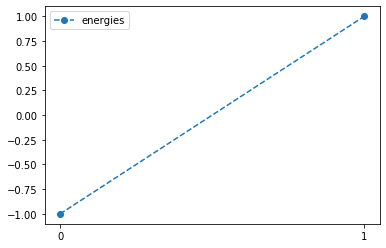

result =  -1.0


In [24]:
O = tq.Objective.ExpectationValue(U=U, H=H)
result = tq.optimizer_scipy.minimize(objective=O, initial_values = {"a": 0.012868225367150547, "b": 0.057727881592791484}, tol=1.e-4, samples=1, method="Powell")
result.history.plot('energies')
print("result = ", result.energy)

## 3: Which Simulator was used and how can I choose the simulator?

You can pass down the simulator to the optimizer by the simulator keyword (see below)
If no specific simulator was chosen by you that means the simulator is automatically picked. Which simulator is picked depends on what simulators you have installed and if you demanded a full wavefunction to be simulated or not.

You can check which simulators you have installed with the following

In [15]:
print(tq.simulators.show_available_simulators())

Supported Backends:

qulacs
qiskit
cirq
pyquil
symbolic
Installed Wavefunction Simulators:

qulacs
pyquil
qiskit
cirq
symbolic

Installed Wavefunction Samplers:

qiskit
cirq
None


Here is how you would initialize a simulator and pass it down the optimizer.
The if statement is just to prevent your Ipython kernel from crashing when you have not installed the simulator
Feel free to change it to something you have installed

ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting BFGS optimization
Objective: 1 expectationvalues
Gradients: 10 expectationvalues (min=2, max=8)

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
E= 0.0002493756473995745  angles= {a: 0.1, b: 0.1}  samples= None
E= 0.0002195803972426802  angles= {a: 0.09501664191484452, b: 0.09751456081867219}  samples= None
E= 0.00012320707901380956  angles= {a: 0.07508320957422257, b: 0.0875728040933609}  samples= None
E= 1.5390127373393625e-05  angles= {a: 0.030551060312040093, b: 0.06600833950542084}  samples= None
E= 2.388447683188133e-06  angles= {a: 0.012868225367150547, b: 0.057727881592791484}  samples= None
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5


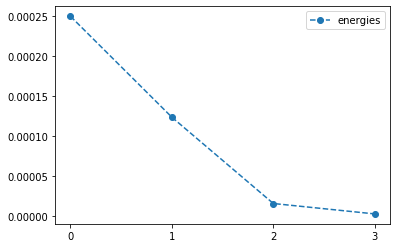

In [16]:
if tq.simulators.HAS_QISKIT:
    O = tq.Objective.ExpectationValue(U=U, H=H)
    result = tq.optimizer_scipy.minimize(objective=O,
                                       initial_values=initial_values,
                                       backend="qiskit")
    result.history.plot()

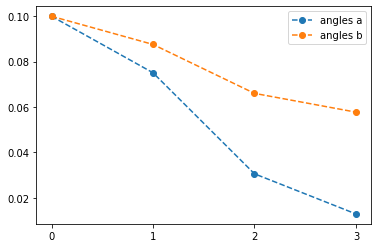

In [17]:
result.history.plot('angles')

# Exercises

See farther down for solutions

## Exercise 1

You can pass down initial_values to the optimizer in the same format as you can do it with the circuit (see above).
Figure out how to do that by checking out the documentation of the 'minimize' function.

## Exercise 2
Figure out which method the optimizer above used and how to use a different optimization method. To do so check out the documentation of the 'minimize' function

In [18]:
# hint
tq.optimizer_scipy.available_methods()

['NELDER-MEAD',
 'COBYLA',
 'POWELL',
 'SLSQP',
 'L-BFGS-B',
 'BFGS',
 'CG',
 'DOGLEG',
 'TNC']

## Exercise 3
If you initialize both parameters to 0.0 you will directly hit a stationary point which causes the optimizer stop.
Find out how you can impose bounds on the variables in order to prevent the optimizer from hitting that point.

Again: Check the documentation of the 'minimize' function.

Note: Not all optimization methods of SciPy support bounds on the variables

Note: It is not enough to just restrict the point 0.0

# Solutions

## Exercise 1 & 2

ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting TNC optimization
Objective: 1 expectationvalues
Gradients: 10 expectationvalues (min=2, max=8)

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
E= -0.0009950108360499144  angles= {a: -0.2, b: -0.1}  samples= None
E= -0.000995011068880558  angles= {a: -0.20000001318133642, b: -0.10000001107599656}  samples= None
E= -0.004511408973485231  angles= {a: -0.30904284100215607, b: -0.19162637937807753}  samples= None
E= -0.10382333397865295  angles= {a: -0.8542570460129364, b: -0.6497582762684649}  samples= None
E= -0.9152603149414062  angles= {a: -9.045845130605263, b: -7.532975465491875}  samples= None
E= -0.9152603149414062  angles= {a: -9.045845235351322, b: -7.532975618103291}  samples= None
E= -0.8058367371559143  angles= {a: -9.684880489707156, b: -8.464028076891404}  samples= None
E= -0.9887020587921143  angles= {a: -9.36536281015621, b: -7.99850177119164}  sampl

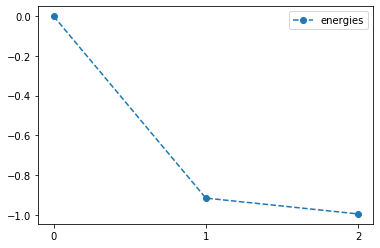

In [19]:
O = tq.Objective.ExpectationValue(U=U, H=H)
result = tq.optimizer_scipy.minimize(objective=O, method='TNC', maxiter=10, initial_values={'a':-0.2, 'b':-0.1})
result.history.plot()

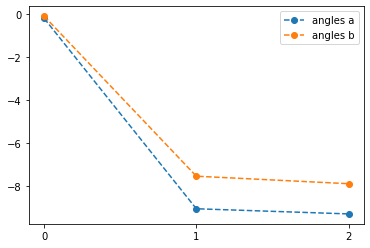

In [20]:
result.history.plot('angles')

## Exercise 3

ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting TNC optimization
Objective: 1 expectationvalues
Gradients: 10 expectationvalues (min=2, max=8)

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
E= 0.0  angles= {a: 0.0, b: 0.0}  samples= None
E= 0.0  angles= {a: 0.0, b: 0.0}  samples= None


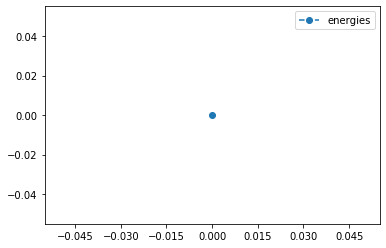

In [21]:
# this will get stuck (similar for other gradient based optimizers)
zeroes = {'a':0.0, 'b':0.0}
shift = 1.0
O = tq.Objective.ExpectationValue(U=U, H=H)
result = tq.optimizer_scipy.minimize(objective=O, method='TNC', initial_values=zeroes)
result.history.plot()

ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting TNC optimization
Objective: 1 expectationvalues
Gradients: 10 expectationvalues (min=2, max=8)

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
E= -0.0002493756473995745  angles= {a: -0.1, b: -0.1}  samples= None
E= -0.0002493764623068273  angles= {a: -0.10000013847589928, b: -0.1000000690645586}  samples= None
E= -0.0011288706446066499  angles= {a: -0.1801468833662514, b: -0.1399730865765343}  samples= None
E= -0.02733689732849598  angles= {a: -0.5808813001975075, b: -0.33983851945920485}  samples= None
E= -1.9026305380975828e-05  angles= {a: -6.183185307179586, b: -3.1339756548460245}  samples= None
E= -0.9720498323440552  angles= {a: -3.3820333036885466, b: -1.7369070871526149}  samples= None
E= -0.6027675867080688  angles= {a: -1.9814573019430273, b: -1.03837280330591}  samples= None
E= -0.9322025775909424  angles= {a: -2.6817453028157874, b: -1.3876399452292

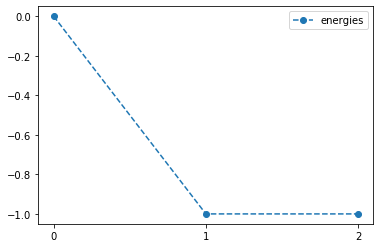

In [22]:
# bounding the variables to keep it away from the stationary point which occurs at 0 and is periodic in 2pi
# using negative values since that converges faster
zeroes = {'a':0.0, 'b':0.0}
shift = 1.0
bounds = {'a':(-2*numpy.pi+0.1, -0.1), 'b':(-2*numpy.pi+0.1, -0.1) }
O = tq.Objective.ExpectationValue(U=U, H=H)
result = tq.optimizer_scipy.minimize(objective=O, method='TNC', initial_values=zeroes, method_bounds=bounds)
result.history.plot()

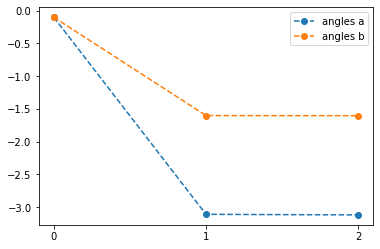

In [23]:
result.history.plot('angles')